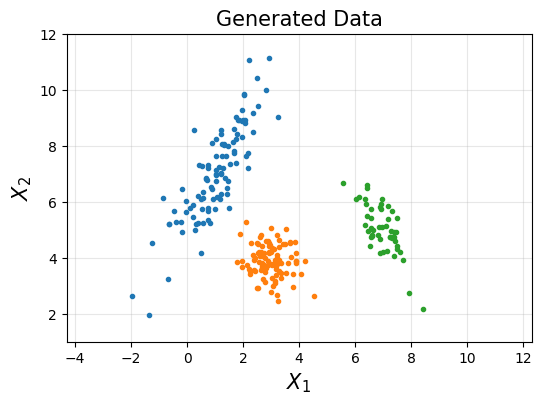

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## generate three simulated clusters

mu1 = np.array([1, 7])
SIGMA1 = 0.8*np.array([[1, 1.5],
                       [1.5, 3]])
X1 = np.random.multivariate_normal(mu1, SIGMA1, 100)

mu2 = np.array([3, 4])
SIGMA2 = 0.3*np.array([[1, 0],
                       [0, 1]])
X2 = np.random.multivariate_normal(mu2, SIGMA2, 100)

mu3 = np.array([7, 5])
SIGMA3 = 0.3*np.array([[1, -1],
                       [-1, 2]])
X3 = np.random.multivariate_normal(mu3, SIGMA3, 50)

plt.figure(figsize = (6, 4))
plt.title('Generated Data', fontsize = 15)
plt.plot(X1[:, 0], X1[:, 1], '.')
plt.plot(X2[:, 0], X2[:, 1], '.')
plt.plot(X3[:, 0], X3[:, 1], '.')
plt.xlabel('$X_1$', fontsize = 15)
plt.ylabel('$X_2$', fontsize = 15)
plt.axis('equal')
plt.grid(alpha = 0.3)
plt.axis([-2, 10, 1, 12])
plt.show()

Train accuracy: 1.0


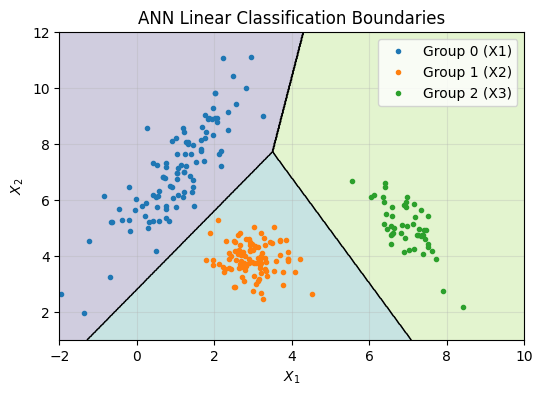

(4,4) predicted group = 1
class probabilities = [5.457810e-07 9.932018e-01 6.797689e-03]


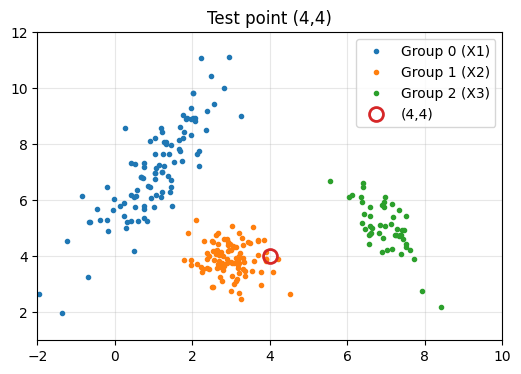

In [ ]:
#학습 데이터(X)와 라벨(y) 구성

X = np.vstack([X1, X2, X3]) # 모든 데이터를 하나의 배열로 결합 (250×2)

y = np.hstack([
    np.zeros(len(X1), dtype=int),# X1 → 클래스 0
    np.ones(len(X2), dtype=int),# X2 → 클래스 1
    2*np.ones(len(X3), dtype=int)# X3 → 클래스 2
])

# 입력 변수 표준화 (평균 0, 분산 1)
# ANN 학습 안정성 및 수렴 속도 향상
mean = X.mean(axis=0)
std  = X.std(axis=0)
Xn = (X - mean) / std


# ANN 모델 설계 및 학습

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42) # TensorFlow 난수 고정

# ANN 모델 정의
model = keras.Sequential([
    layers.Input(shape=(2,)),# 입력층 (x1, x2)
    layers.Dense(3, activation='softmax')
    # 출력층: 클래스 3개 → softmax
    # 은닉층이 없으므로 결정경계 직선
])

# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),# 최적화 알고리즘
    loss='sparse_categorical_crossentropy',# 다중 클래스 손실함수
    metrics=['accuracy'] # 정확도 평가
)

# 모델 학습
model.fit(
    Xn, y,# 입력 데이터와 라벨
    epochs=300,# 학습 반복 횟수
    batch_size=32,# 미니배치 크기
    verbose=0# 학습 로그 출력 안 함
)

# 학습 정확도 확인
loss, acc = model.evaluate(Xn, y, verbose=0)
print("Train accuracy:", acc)

# 선형 결정영역, 결정경계 시각화

def plot_linear_boundaries(model, X_raw, y, mean, std,
                           xlim=(-2,10), ylim=(1,12), step=0.02):
    # x1, x2 공간에서 격자 생성
    xs = np.arange(xlim[0], xlim[1], step)
    ys = np.arange(ylim[0], ylim[1], step)
    xx, yy = np.meshgrid(xs, ys)

    # 격자 좌표를 (N,2) 형태로 변환
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 격자 데이터도 학습 데이터와 동일하게 표준화
    grid_n = (grid - mean) / std

    # ANN 모델로 클래스 예측
    probs = model.predict(grid_n, verbose=0)
    pred = np.argmax(probs, axis=1).reshape(xx.shape)

    # 결정영역(배경 색)
    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, pred, alpha=0.25,
                 levels=[-0.5, 0.5, 1.5, 2.5])

    # 결정경계(클래스가 바뀌는 직선)
    plt.contour(xx, yy, pred, colors='k',
                linewidths=1, levels=[0.5, 1.5])

    # 원본 데이터 표시
    plt.plot(X_raw[y==0,0], X_raw[y==0,1], '.', label='Group 0 (X1)')
    plt.plot(X_raw[y==1,0], X_raw[y==1,1], '.', label='Group 1 (X2)')
    plt.plot(X_raw[y==2,0], X_raw[y==2,1], '.', label='Group 2 (X3)')

    plt.title('ANN Linear Classification Boundaries')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# 결정경계 플롯 실행
plot_linear_boundaries(model, X, y, mean, std)

# (x1, x2) = (4, 4) 분류

test_pt = np.array([[4.0, 4.0]])# 테스트 포인트 정의
test_pt_n = (test_pt - mean) / std# 동일한 방식으로 표준화

test_prob = model.predict(test_pt_n, verbose=0)[0]# 클래스별 확률
test_cls = int(np.argmax(test_prob))# 가장 큰 확률의 클래스

print("(4,4) predicted group =", test_cls)
print("class probabilities =", test_prob)

# 테스트 포인트 시각화
plt.figure(figsize=(6,4))
plt.title('Test point (4,4)')
plt.plot(X1[:,0], X1[:,1], '.', label='Group 0 (X1)')
plt.plot(X2[:,0], X2[:,1], '.', label='Group 1 (X2)')
plt.plot(X3[:,0], X3[:,1], '.', label='Group 2 (X3)')
plt.plot(4, 4, 'o', markersize=10, markeredgewidth=2,
         fillstyle='none', label='(4,4)')
plt.xlim(-2,10)
plt.ylim(1,12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()